# Import Dependencies and Define Functions

In [350]:
#!/usr/bin/env python
# coding: utf-8

# # Import Dependencies and Define Functions

%matplotlib notebook

#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import os
from tkinter import Tk
from tkinter.filedialog import askdirectory
from iapws import IAPWS97 as steam_prop
import matplotlib.animation as animation
from matplotlib.widgets import Slider
import itertools
import PIL
np.seterr(all='raise')


#Define critical pressure ratio
alpha = 0.55

#Define a function that calculates the density for a given pressure and temperature
def calc_rho(p, t):
    
    #convert psia to MPA
    pressure = p*0.00689476
    
    #convert farenheit to Kelvin
    temp = (t - 32)*5/9 + 273.15
    
    #get the density 
    r = steam_prop(P=pressure, T=temp).v
    rho = steam_prop(P=pressure, T=temp).rho
    
    #convert density from kg/M^3 to lb/ft^3
    rho = rho*0.062428
    
    return rho

#piecewise linear fit
def piecewise_linear(x, y0, y1, b0, b1, b2):
    global x0
    global x1

    return np.piecewise(x, 
                        [x < x0, 
                         (x >= x0) & (x < x1), 
                         x >= x1], 
                        [lambda x: b0*x + y0, 
                         lambda x: b1*x + y1-b1*x1,
                         lambda x: b2*x + y1-b2*x1])

    
#Function for getting user input on curve fitting
def user_plot_fit(x0_start, x1_start, title, xdata, ydata, xlabel, ylabel, xunits, yunits):
    
    #re-initialize global x0 - assumption for first breakpoint
    #re-initialize global x1 - assumption for second breakpoint
    global x0 
    global x1
    x0 = x0_start
    x1 = x1_start

    #optimize piecewise fit with user-defined breakpoints
    p, e = optimize.curve_fit(piecewise_linear, xdata, ydata)

    #Define range for governor demand model
    model_x = np.linspace(-1, 100, 100)

    # Create figure and axis objects
    fig, ax = plt.subplots()

    #add plot labels
    plt.title(f"Use Sliders to Adjust Curve Fit!\n\n{title}")
    plt.ylabel(f"{ylabel}\n({yunits})")
    plt.xlabel(f"{xlabel}\n({xunits})")

    #plot historical/design data
    data, = plt.plot(xdata, ydata, 'o')

    #plot piecewise curve fit
    fit, = plt.plot(model_x, piecewise_linear(model_x, *p))

    #left, bottom, width, height
    ax_break1 = plt.axes([0.25, 0.05, 0.50, 0.02])
    ax_break2 = plt.axes([0.25, 0.02, 0.50, 0.02])

    #Create slider animations for the breakpoints
    slider1 = Slider(ax_break1, 'Breakpoint 1', 0, 100, valinit=x0_start)
    slider2 = Slider(ax_break2, 'Breakpoint 2', 0, 100, valinit=x1_start)
    
    def update(val):
        global x0
        global x1
        x0 = slider1.val
        x1 = slider2.val
        # update curve
        p, e = optimize.curve_fit(piecewise_linear, xdata, ydata)
        fit.set_ydata(piecewise_linear(model_x, *p))
        # redraw canvas while idle
        fig.canvas.draw_idle()

    # call update function on slider value change
    slider1.on_changed(update)
    slider2.on_changed(update)

    #show plot
    plt.tight_layout(pad=4)
    plt.show()

    #Save results to DataFrame
    dictionary = {
        xlabel : ax.get_children()[1]._x,
        ylabel : ax.get_children()[1]._y
        }
     
    model_df = pd.DataFrame(dictionary)
    model_df.to_csv(f"projects/{project}/{ylabel}_model.csv")
    
    return model_df

#define a function that gets the flow regime for a given jratio nd pratio
def get_regime(jratio, pratio):
    # return 1 if "Neither Choked"
    # return 2 if "Governor Choked"
    # return 3 if "Nozzle Choked"
    # return 4 if "Both Choked"
    
    global alpha
    
    #Define the intersection of the curves
    triple_point = alpha + (alpha - 1) *0.55**2/alpha
    
    #if jratio is to the right of the triple point, test for neither choked or nozzle choked
    if jratio > 0.55:
        
        #define the limit below which the nozzle is choked
        limit = alpha*jratio*(jratio-(-4*alpha+jratio**2+4)**0.5)/(2*(alpha-1))
        
        #test if the pratio is in "neither choked" or "nozzle choked" regime
        if pratio > limit:
            return 1
        else:
            return 3
    
    #if jratio is to the left of the triple point, test for neither choked, governor choked, or both choked
    else:
        
        #define the limit below which both are choked
        limit = triple_point/alpha*jratio
        
        #if the pratio is below the limit, the flow is "both choked"
        if pratio < limit:
            return 4
        
        #if not, define the limit below which the governover is choked
        else:
            limit = alpha + (alpha-1)*jratio**2/alpha
            
            #if the pratio is below the limit, the flow is "governor choked"
            if pratio < limit:
                return 2
            else:
                return 1

#Define a function that calculates the Bowl Pressure Ratio from flow regime, jratio, and pratio
#case 1 neither choked
# pbr = 1/2(-jr^2 + pxr + sqrt(4*jr^2 + jr^4 - 2*jr^2*pxr + pxr^2))
# flow = jr*sqrt(rho_in*(1-pbr))

#case 2 governor choked
#pbr = 1/2(pxr + sqrt(4*jr^2 +pxr^2 - 4*jr^2*alpha))
# flow = jr*sqrt(rho_in*(1-alpha)) 

#case 3 nozzle choked
#pbr = 1/2( - jr^2/(1-alpha) - jrsqrt(4+jr^2-4*alpha)/(-1+alpha))
#flow = jr*sqrt(rho_in*(1-pbr))

#case 4 nozzle choked
#pbr = jr
#flow = jr*sqrt(rho_in*(1-alpha))

def calc_pbr(regime, j_ratio, p_ratio):
        
        #Use notebook alpha
        global alpha
        
        if regime == 1:
            
            #Calculate bowl pressure
            pbr = 0.5*(-j_ratio**2 + p_ratio + (4*j_ratio**2 + j_ratio**4 - 2*p_ratio*j_ratio**2 + p_ratio**2)**0.5)

        elif regime == 2:
            #pbr = 1/2(pxr + sqrt(4*jr^2 +pxr^2 - 4*jr^2*alpha))

            #Calculate bowl pressure
            pbr = 0.5*(p_ratio + (4*j_ratio**2 + p_ratio**2 - 4*j_ratio**2*alpha)**0.5)

        elif regime == 3:
            #pbr = 1/2( - jr^2/(1-alpha) - (jr/(-1+alpha))*sqrt(4+jr^2-4*alpha))
            
            #Calculate bowl pressure
            pbr = 0.5*(-j_ratio**2/(1-alpha) -(j_ratio/(alpha-1))*((4+j_ratio**2 - 4*alpha)**0.5))

        elif regime == 4:
            
            #pbr =??????

            #Calculate bowl pressure
            pbr = j_ratio
        
        return pbr

    
#Define a function that calculates the flow in KPPH from flow regime, inlet pressure, governor j, and pb
def calc_flow(regime, pi, pb, jgv, r):

        #Use notebook alpha
        global alpha
        
        if (regime == 1):

            flow = 3.6*jgv*(r*(pi-pb))**0.5
        
        elif regime ==3:
            
            flow = 3.6*jgv*(r*(pi-pb))**0.5

        elif regime == 2:

            flow = 3.6*jgv*(r*(alpha*pi))**0.5
        
        elif regime ==4:
            
            #PLACEHOLDER
            flow = 3.6*jgv*(r*(alpha*pi))**0.5
        
        return flow
    

#Define a function that calculates the Jgov from flow regime, bowl pressure, inlet pressure, inlet density, and flow
def solve_j(regime, pi, pb, r, flow):
    
    #Use notebook alpha
    global alpha
    
    if (regime == 1):

        #flow = 3.6*jgv*(r*(pi-pb))**0.5
        jgv = flow/3.6/((r*(pi-pb))**0.5)

    elif regime ==3:

        #flow = 3.6*jgv*(r*(pi-pb))**0.5
        jgv = flow/3.6/(r*(pi-pb))**0.5

    elif regime == 2:

        #flow = 3.6*jgv*(r*(alpha*pi))**0.5
        jgv = flow/3.6/(r*(alpha*pi))**0.5

    elif regime ==4:
        
        #PLACEHOLDER
        #flow = 3.6*jgv*(r*(alpha*pi))**0.5
        jgv = flow/3.6/(r*(alpha*pi))**0.5

    return jgv

    
# ## Define Trim Curves
# The lifts to evaluate at are pre-determined
def define_trim(res, trim_guesses):
    
    global gov_no

    #guesses = [[gv1 0, 50, 100, 25....], [gv2 0, 50, 100, 25...]

    # initialize
    trims_list = []
    
    for x in range(gov_no):
        
        lift_list = [0,100]
        area_list = [0,100]
        
        #Define the lifts
        for i in range(res):
            lift_list.insert(i+1, 100/(1+res)*(i+1))
        
            area_list.insert(i+1, trim_guesses[x][i])
    
        trims_list.append(lift_list)
        trims_list.append(area_list)

    #Create a list of column titles for Pandas dataframe
    titles = []
    for i in range(gov_no):
        titles.append("GV"+str(i+1)+" lift")
        titles.append("GV"+str(i+1)+" area")

    #Define a dictionary of the governor trim curves
    dictionary = {}
    for i in range(gov_no):
        dictionary.update({titles[2*i] : trims_list[2*i]})
        dictionary.update({titles[2*i+1] : trims_list[2*i+1]})

    #Use dictionary to create a pandas dataframe
    gv_trim_df = pd.DataFrame(dictionary)

    #Save Dataframe to csv
    gv_trim_df.to_csv(f"projects/{project}/gov_trim_curve.csv")
    
    return gv_trim_df


def calc_ks(performance_df, gov_noz_ratios):
    #---------------------------------------------
    #---------------------------------------------
    #
    # Calculate the govenor and nozzle flow coeffiecients for the given governor_k / nozzle_k ratio
    #
    #---------------------------------------------
    #---------------------------------------------
    global gov_no
    
    #determine the flow at 100% governor demand 
    max_flow = performance_df.loc[performance_df["Governor Demand"] == 100, "Steam Flow Target"].to_list()[0]

    #Determine the throttle pressure at 100% governor demand
    max_tp = performance_df.loc[performance_df["Governor Demand"] == 100, "Throttle Pressure"].to_list()[0]

    #determine the p_ratio at 100% governor demand
    max_p_ratio = performance_df.loc[performance_df["Governor Demand"] == 100, "Px/Pi"].to_list()[0]

    #determine the bowl densities at 100% governor demand   
    max_rho = performance_df.loc[performance_df["Governor Demand"] == 100, "Inlet Density"].to_list()[0]
    
    #determine the first stage pressure at 100% governor demand
    max_fsp = performance_df.loc[performance_df["Governor Demand"] == 100, "First Stage Pressure"].to_list()[0]

    
    max_regime = []
    max_pb = []
    max_rb = []
    factor = 0
    #For each governor valve, determine the flow regime at 100% governor demand
    for i in range(gov_no):
        max_regime.append(get_regime(gov_noz_ratios[i], max_p_ratio))
        
        #Calculate the bowl pressure
        max_pb.append(max_tp * calc_pbr(max_regime[i], gov_noz_ratios[i], max_p_ratio))
        
        #determine the bowl densities at 100% governor demand
        max_rb.append(max_rho*max_pb[i]/max_tp)
                      
        if max_regime[i] < 3:
        #nozzle not choked
                      
            factor = factor + (max_rb[i]*(max_pb[i] - max_fsp))**0.5

        else:
        #nozzle choked
            
            factor = factor + (max_rb[i]*alpha*max_pb[i])**0.5

                      
    #Calculate the necessary jgov and jnoz
    noz_k = max_flow/3.6/factor
    
    #Create list for governor valve Ks
    gov_ks = []
    for i in range(gov_no):
        gov_ks.append(noz_k*gov_noz_ratios[i])
    
    return (gov_ks, noz_k)


def calc_performance(parameters, performance_df, low_err, iteration):

    global gov_no
    #guess is a list which begins with the individual gov / noz ratios, and then the trim points
    #p_lists[0] = gov/noz ratios
    #p_lists[1] = trim points at 6.25
    #p_lists[8] = trim points at 93.75
    
    res = int((len(parameters) - gov_no)/gov_no)
    p_lists=[]

    p_lists.append(guess[:8])
    for i in range(gov_no):
        sliceObj = slice(8+i*res, 8+(i+1)*res)
        p_lists.append(parameters[sliceObj])

    gov_noz_ratios = p_lists[0]

    trim_intermed = []
    for i in range(gov_no):

        #define the number to base the guess on 
        trim_intermed.append(p_lists[i+1])

    #rint(trim_intermed[0])
    trim_guess_indiv = []

    #rint(res)
    trim_guess = []
    for x in range(gov_no):
        trim_guess_indiv = []
        if res == 1:
            trim_guess_indiv.append(100*trim_intermed[x][0])
        else:
            trim_guess_indiv.append(100*trim_intermed[x][0])
            for i in range(res-1):
                trim_guess_indiv.append(trim_guess_indiv[i]*trim_intermed[x][i+1])
        trim_guess_indiv.reverse()
        trim_guess.append(trim_guess_indiv)
            
    trim_df = define_trim(res, trim_guess)
    
    #rint(trim_df)
    
    (gov_k_list, noz_k) = calc_ks(performance_df, gov_noz_ratios)
    #---------------------------------------------
    #---------------------------------------------
    #
    # Calculate Flow Coefficients and Predicted Flows 
    #
    #---------------------------------------------
    #---------------------------------------------
    
    #rint(gov_k_list)
    #print(noz_k)
    
    global single_dmd_df
    global seq_demand_df
    
    gov_dmd = performance_df.loc[:,"Governor Demand"].to_list()
    p_ratio = performance_df.loc[:, "Px/Pi"].to_list()
    tp = performance_df.loc[:, "Throttle Pressure"].to_list()
    rho = performance_df.loc[:, "Inlet Density"].to_list()

    for i in range(gov_no):

        #ITERATE OVER GVs
        #re-initialize problem
        single_j_list = []
        single_jratio_list = []
        single_region_list = []
        single_pb_list = []
        single_f_list = []

        seq_j_list = []
        seq_jratio_list = []
        seq_region_list = []
        seq_pb_list = []
        seq_f_list = []

        for x in range(len(gov_dmd)):

                #----------------------------------------------------------
                #Calculate the jratio and flow regime for single valve mode
                #----------------------------------------------------------

                #Calculate the valve lift
                try:
                    single_lift = np.interp(gov_dmd[x], single_dmd_df["Governor Demand"], single_dmd_df["Valve Position Demand"])
                except:
                    print("single_lift")
                    
                #Calculate the valve area
                try:
                    single_j_list.append(gov_k_list[i]/100*np.interp(single_lift, trim_df[f"GV{i+1} lift"], trim_df[f"GV{i+1} area"]))
                except:
                    print("single_j_list")
                
                #calculate the jratio
                try:
                    single_jratio_list.append(single_j_list[x]/noz_k)
                except:
                    print("single_jratio_list")

                #determine the flow regime for each governor valve
                try:
                    single_region_list.append(get_regime(single_jratio_list[x], p_ratio[x]))
                except:
                    print("single_region_list")
                #----------------------------------------------------------
                # Calculate Pb and flow for single valve mode
                #----------------------------------------------------------
                try:
                    pbowl =  tp[x] * calc_pbr(single_region_list[x], single_jratio_list[x], p_ratio[x])
                except:
                    print("single_pbowl")
                
                single_pb_list.append(pbowl)

                #Calculate flow
                try:
                    single_f_list.append(calc_flow(single_region_list[x], tp[x], pbowl, single_j_list[x], rho[x]))
                except:
                    print("single_f_list")


                #----------------------------------------------------------
                #Calculate the jratio and flow regime for sequential valve mode
                #----------------------------------------------------------

                #Calculate the valve lift
                seq_lift = np.interp(gov_dmd[x], seq_dmd_df.iloc[:,2*i], seq_dmd_df.iloc[:,2*i+1])

                #Calculate the valve area
                seq_j_list.append(gov_k_list[i]/100*np.interp(seq_lift, trim_df[f"GV{i+1} lift"], trim_df[f"GV{i+1} area"]))
                
                #calculate the jratio
                seq_jratio_list.append(seq_j_list[x]/noz_k)

                #determine the flow regime for each governor valve
                seq_region_list.append(get_regime(seq_jratio_list[x], p_ratio[x]))

                #----------------------------------------------------------
                # Calculate Pb and flow for sequential valve mode
                #----------------------------------------------------------

                pbowl =  tp[x] * calc_pbr(seq_region_list[x], seq_jratio_list[x], p_ratio[x])
                seq_pb_list.append(pbowl)

                #Calculate flow in KPPH
                seq_f_list.append(calc_flow(seq_region_list[x], tp[x], pbowl, seq_j_list[x], rho[x]))



        performance_df[f"Single Flow Coefficient {i+1}"] = single_j_list
        performance_df[f"Single Flow Region {i+1}"] = single_region_list
        performance_df[f"Single J Ratio {i+1}"] = single_jratio_list
        performance_df[f"Single Bowl Presusre {i+1}"] = single_pb_list
        performance_df[f"Single Flow {i+1}"] = single_f_list


        performance_df[f"Sequential Flow Coefficient {i+1}"] = seq_j_list
        performance_df[f"Sequential Flow Region {i+1}"] = seq_region_list
        performance_df[f"Sequential J Ratio {i+1}"] = seq_jratio_list
        performance_df[f"Sequential Bowl Presusre {i+1}"] = seq_pb_list
        performance_df[f"Sequential Flow {i+1}"] = seq_f_list

        #ITERATE OVER GVs


    single_flow_list = []
    seq_flow_list = []

    for i in range(len(gov_dmd)):

        total_flow_single = 0
        total_flow_seq =0
        for x in range(gov_no):
            total_flow_single += performance_df[f"Single Flow {x+1}"].tolist()[i]
            total_flow_seq  += performance_df[f"Sequential Flow {x+1}"].tolist()[i]

        single_flow_list.append(total_flow_single)
        seq_flow_list.append(total_flow_seq)

    performance_df["Total Single Flow"] = single_flow_list
    performance_df["Total Sequential Flow"] = seq_flow_list

    #---------------------------------------------
    #---------------------------------------------
    #
    # END: Calculate Flow Coefficients and Predicted Flows 
    #
    #---------------------------------------------
    #---------------------------------------------

      
    #Calculate error
    #error = ((performance_df["Total Single Flow"] - performance_df["Steam Flow Target"])**2 + \
    #        (performance_df["Total Sequential Flow"] - performance_df["Steam Flow Target"])**2).sum()
    error = ((performance_df["Total Single Flow"] - performance_df["Steam Flow Target"])**2).sum()
    
    #Save the plot if the current error is lowest error so far
    if error < low_err:
        fig, ax = plt.subplots()

        plt.plot(performance_df["Governor Demand"], performance_df["Steam Flow Target"])
        plt.plot(performance_df["Governor Demand"], performance_df["Total Single Flow"])
        plt.plot(performance_df["Governor Demand"], performance_df["Total Sequential Flow"])
        plt.legend(["Target", "Single", "Sequential"],loc="best")
        plt.title("Steam Flow vs. Governor Demand")
        plt.xlabel("Govenor Demenad\n(%)")
        plt.ylabel("Steam Flow\n (KPPH)")
        plt.tight_layout()
        #plt.show()

        fig.savefig(f'projects/{project}/plot{iteration}.png')

    
    elif iteration == 0:
        
        fig, ax = plt.subplots()

        plt.plot(performance_df["Governor Demand"], performance_df["Steam Flow Target"])
        plt.plot(performance_df["Governor Demand"], performance_df["Total Single Flow"])
        plt.plot(performance_df["Governor Demand"], performance_df["Total Sequential Flow"])
        plt.legend(["Target", "Single", "Sequential"],loc="best")
        plt.title("Steam Flow vs. Governor Demand")
        plt.xlabel("Govenor Demenad\n(%)")
        plt.ylabel("Steam Flow\n (KPPH)")
        plt.tight_layout()
        plt.show()

        fig.savefig(f'projects/{project}/plot{iteration}.png')
    
    return error

In [4]:
# # Open a Project

#Ask if user would like to open a project
open_flag = input("Would you like to return to an existing project?(y/n)")

#If user requests to open project, request project name
if open_flag == "y":
    try:
        path = askdirectory(title="Select Project Folder")
    except:
        print("File open failed.")

# In[4]:
    #get project name
    list_path = path.split(sep="/")
    open_project = list_path[-1]
    project = open_project

    #Load available dataframes
    try:
        single_dmd_df = pd.read_csv(f"projects/{open_project}/single_dmd_curve.csv")
    except:
        print("Couldn't load 'single_dmd_curve.csv' from project")
        
    try:
        seq_dmd_df = pd.read_csv(f"projects/{open_project}/sequential_dmd_curve.csv")
        #Use integer division to get number of governor valves
        gov_no = len(seq_dmd_df.columns)//2
    except:
        print("Couldn't load 'sequential_dmd_curve.csv' from project")
        
    try:
        design_df = pd.read_csv(f"projects/{open_project}/design_data.csv")
    except:
        print("Couldn't load 'design_data.csv' from project")
    
    try:
        steam_flow_model_df = pd.read_csv(f"projects/{open_project}/steam_flow_model.csv")
    except:
        print("Couldn't load 'design_data.csv' from project")
    
    try:
        tp_model_df = pd.read_csv(f"projects/{open_project}/tp_model.csv")
    except:
        print("Couldn't load 'design_data.csv' from project")
    
    try:
        steam_temp_model_df = pd.read_csv(f"projects/{open_project}/steam_temp_model.csv")
    except:
        print("Couldn't load 'design_data.csv' from project")
    
    try:
        first_stage_model_df = pd.read_csv(f"projects/{open_project}/first_stage_model.csv")
    except:
        print("Couldn't load 'design_data.csv' from project")
    
# # Define a New Project

else:
    #Get a project name from the user
    project = input("What would you like to call this project?")

    #Create a Directory for the project
    try:
        os.mkdir("projects")
    except:
        print("Couldn't make new 'projects' directory")
    try:
        os.mkdir(f"projects/{project}")
    except:
        print(f"Couldn't make new '{project}' directory")


    # # Define Single Mode Governor Demand to Valve Position Curve

    #Import Governor Demand to Single Valve Demand curve
    #user_x = input("Enter the x values for Single Valve Mode")
    #user_y = input("Enter the y values for Single Valve Mode")
    #list_x = user_x.split()
    #list_y = user_y.split()
        
    #convert list of strings to list of floats
    #x_axis = [float(i) for i in list_x]
    #y_axis = [float(i) for i in list_y]
        
    #Tell user what was entered
    #print(f"You entered {len(x_axis)} x values and {len(y_axis)} y values")
    #data = {"Governor Demand" : x_axis, "Valve Position Demand" : y_axis}
    #single_dmd_df = pd.DataFrame(data)

    single_dmd_df = pd.read_csv("data/single_dmd_curve.csv")

    #Save Dataframe to csv
    single_dmd_df.to_csv(f"projects/{project}/single_dmd_curve.csv")

    #plot the governor demand single valve curve
    plt.plot(single_dmd_df["Governor Demand"], single_dmd_df["Valve Position Demand"], "o-")
    plt.title("Single Valve Mode\nValve Position Demand vs Governor Demand\n")
    plt.ylabel("Valve Position Demand (%)")
    plt.xlabel("\nGovernor Valve Demand (%)")
    plt.tight_layout()

    #save the figure to the project directory
    plt.savefig(f"projects/{project}/single_dmd_curve.png")


    # # Define Sequential Mode Governor Demand to Valve Positions Curves

    #Get number of governor valves from the user
    gov_no = int(input("How many governor valves are there?"))

    #Create a list of column titles for Pandas dataframe
    #titles = []
    #for i in range(gov_no):
    #    titles.append("GV"+str(i+1)+" x")
    #    titles.append("GV"+str(i+1)+" y")
    #print(titles)

    #For each governor valve enter the
    #gv_demand_curves = []
    #for i in range(gov_no):
    #    user_x = input(f"Copy the x values for GV #{i+1} ")
    #    user_y = input(f"Copy the y values for GV #{i+1} ")
    #    list_x = user_x.split()
    #    list_y = user_y.split()
        
        #convert list of strings to list of floats
    #    list_x = [float(i) for i in list_x]
    #    list_y = [float(i) for i in list_y]
        
    #    #Append lists to the master list
    #    gv_demand_curves.append(list_x)
    #    gv_demand_curves.append(list_y)

    #Define a dictionary of the governor valve demand curves
    #dictionary = {}
    #for i in range(2*gov_no):
    #    dictionary.update({titles[i] : gv_demand_curves[i]})

    #Use dictionary to create a pandas dataframe
    #seq_dmd_df = pd.DataFrame(dictionary)
    seq_dmd_df = pd.read_csv("data/sequential_dmd_curve.csv")

    #Save Dataframe to csv
    seq_dmd_df.to_csv(f"projects/{project}/sequential_dmd_curve.csv")

    #Create a plot of all the governor demand curves
    for i in range(gov_no):
        plt.plot(seq_dmd_df.iloc[:,i*2], seq_dmd_df.iloc[:,i*2+1], 'o-')

    #Create Labels
    legend_list = [f"GV{i+1}" for i in range(gov_no)]
    plt.legend(legend_list)

    #Add labels
    plt.title("Sequential Valve Mode\nValve Position Demand vs Governor Demand\n")
    plt.ylabel("Valve Position Demand (%)")
    plt.xlabel("\nGovernor Valve Demand (%)")

    #save figure
    plt.savefig(f"projects/{project}/sequential_dmd_curve.png")


    # # Define the Design Performance

    #Define the desired performance

    #get a list from the user comparing governor demand and measured steam flow
    #input_dmd = input("input governor demand historical data")
    #input_steam_flow = input("input steam flow historical data")
    #input_throttle_p = input("input throttle pressure historical data")
    #input_steam_temp = input("input main steam temperature historical data")
    #input_1st_p = input("input first stage pressure historical data")
    #input_mwg = input("input Generator MW historical data")

    #split input by spaces
    #list_dmd = input_dmd.split()
    #list_steam_flow = input_steam_flow.split()
    #list_throttle_p = input_throttle_p.split()
    #list_steam_temp = input_steam_temp.split()
    #list_1st_p = input_1st_p.split()
    #list_mwg = input_mwg.split()
        
    #convert list of strings to list of floats
    #list_dmd = [float(i) for i in list_dmd]
    #list_steam_flow = [float(i) for i in list_steam_flow]
    #list_throttle_p = [float(i) for i in list_throttle_p]
    #list_steam_temp = [float(i) for i in list_steam_temp]
    #list_1st_p = [float(i) for i in list_1st_p]
    #list_mwg = [float(i) for i in list_mwg]

    #Define a dictionary of the governor valve demand curves
    #dictionary = {
    #    "Governor Demand (Design)" : list_dmd,
    #    "Steam Flow (Design)" : list_steam_flow,
    #    "Throttle Pressure" : list_throttle_p,
    #    "Main Steam Temperature" : list_steam_temp,
    #    "First Stage Pressure (Design)" : list_1st_p,
    #    "Generator MWG" : list_mwg
    #}

    #Use dictionary to create a pandas dataframe
    #design_df = pd.DataFrame(dictionary)

    design_df = pd.read_csv("data/design_data.csv")
    
    #Save dataframe to csv
    design_df.to_csv(f"projects/{project}/design_data.csv")
    
    #Define Steam Flow Model
    steam_flow_model_df = user_plot_fit(
        33,
        66,
        "Steam Flow vs. Governor Demand",
        design_df["Governor Demand (Design)"].tolist(),
        design_df["Steam Flow (Design)"].tolist(),
        "Governor Demand",
        "Steam Flow",
        "%",
        "KPPH"
    )

    steam_flow_model_df.to_csv(f"projects/{project}/steam_flow_model.csv")

    #Define Throttle Pressure Model
    tp_model_df = user_plot_fit(
        33,
        66,
        "Throttle Pressure vs. Governor Demand",
        design_df["Governor Demand (Design)"].tolist(),
        design_df["Throttle Pressure"].tolist(),
        "Governor Demand",
        "Throttle Pressure",
        "%",
        "psia"
    )

    tp_model_df.to_csv(f"projects/{project}/tp_model.csv")

    #Define Main Steam Temperature Model
    steam_temp_model_df = user_plot_fit(
        33,
        66,
        "Steam Temperature vs. Governor Demand",
        design_df["Governor Demand (Design)"].tolist(),
        design_df["Main Steam Temperature"].tolist(),
        "Governor Demand",
        "Steam Temp",
        "%",
        "F"
    )

    steam_temp_model_df.to_csv(f"projects/{project}/steam_temp_model.csv")


    #Define First Stage Pressure Model
    first_stage_model_df = user_plot_fit(
        33,
        66,
        "First Stage Pressure vs. Governor Demand",
        design_df["Governor Demand (Design)"].tolist(),
        design_df["First Stage Pressure (Design)"].tolist(),
        "Governor Demand",
        "First Stage Pressure",
        "%",
        "psia"
    )

    first_stage_model_df.to_csv(f"projects/{project}/first_stage_model.csv")

Would you like to return to an existing project?(y/n)y


# Create Model Definitions Relating Governor Demand and Flow / Thermo 

In [68]:
#---------------------------------------------
#---------------------------------------------
#
# Define the initial Trim Curves and gov/noz ratio
#
#---------------------------------------------
#---------------------------------------------

#initial trim guess is linear for all valves
linear_trim = [0, 100, 50, 25, 75, 12.5, 62.5, 32.5, 87.5, 6.25]
initial_guess = []
for i in range(gov_no):
    initial_guess.append(linear_trim)
  
trims = define_trim(1, initial_guess)
print(trims)

# Valve Wide Open jgov/jnoz
gov_noz_initial = 1


   GV1 lift  GV1 area  GV2 lift  GV2 area  GV3 lift  GV3 area  GV4 lift  \
0         0         0         0         0         0         0         0   
2        50        50        50        50        50        50        50   
1       100       100       100       100       100       100       100   

   GV4 area  GV5 lift  GV5 area  GV6 lift  GV6 area  GV7 lift  GV7 area  \
0         0         0         0         0         0         0         0   
2        50        50        50        50        50        50        50   
1       100       100       100       100       100       100       100   

   GV8 lift  GV8 area  
0         0         0  
2        50        50  
1       100       100  


In [315]:
#---------------------------------------------
#---------------------------------------------
#
# Calculate the test values using the defined models
#
#---------------------------------------------
#---------------------------------------------

# Define the governor demands to test against

step = int(input("How governor demands do you want to evaluate with? (10 is suggested)"))
gov_dmd = np.arange(0,100+step, step)

#Define the throttle pressure
tp = np.interp(gov_dmd, tp_model_df["Governor Demand"], tp_model_df["Throttle Pressure"])

#Define the steam temperatures
temperature = np.interp(gov_dmd, steam_temp_model_df["Governor Demand"], steam_temp_model_df["Steam Temp"])

#Define the inlet densities
rho = []
for x in range(len(gov_dmd)):
    rho.append(calc_rho(tp[x],temperature[x]))

#Define the first stage pressures
first_p = np.interp(gov_dmd, first_stage_model_df["Governor Demand"], first_stage_model_df["First Stage Pressure"])

#Define the target steam flows
flow_target = np.interp(gov_dmd, steam_flow_model_df["Governor Demand"], steam_flow_model_df["Steam Flow"])

#Define the p_ratio
p_ratio = first_p / tp

dictionary = {
    "Governor Demand" : gov_dmd,
    "Throttle Pressure" : tp,
    "Main Steam Temp" : temperature,
    "Inlet Density" : rho,
    "First Stage Pressure" : first_p,
    "Steam Flow Target" : flow_target,
    "Px/Pi" : p_ratio
}

target_df = pd.DataFrame(dictionary)
target_df.to_csv(f"projects/{project}/target_performance.csv")

How governor demands do you want to evaluate with? (10 is suggested)20


In [320]:
#format initial guess
trim_resolution = int(input("How many trim points do you want to evaluate with?"))

initial_guess = []
for i in range(gov_no):
    initial_guess.append(1)

for x in range(gov_no):  
    
    for i in range(trim_resolution):
        
        initial_guess.append(0.5)

print(initial_guess)

How many trim points do you want to evaluate with?3
[1, 1, 1, 1, 1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


<IPython.core.display.Javascript object>


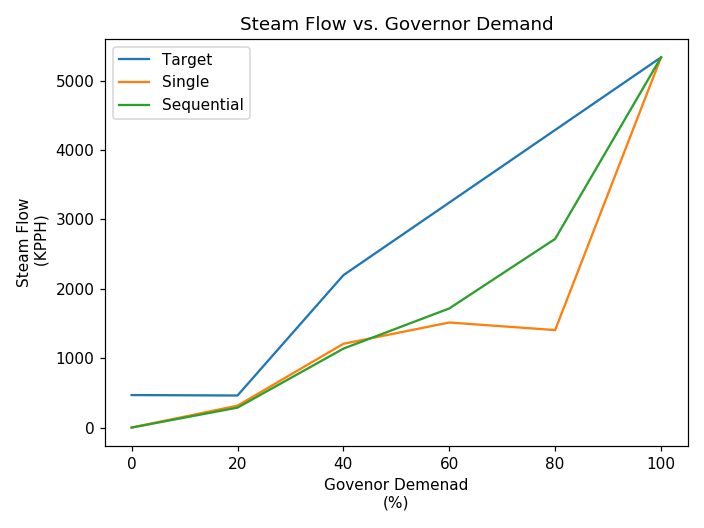

In [351]:
error = calc_performance(initial_guess, target_df, 0, 0)
#---------------------------------------------
#---------------------------------------------
#
# END: Calculate the test values using the defined models
#
#---------------------------------------------
#---------------------------------------------

In [346]:
#---------------------------------------------
#---------------------------------------------
#
# Calculate the performance for different guesses
#
#---------------------------------------------
#---------------------------------------------

# Initial performance 250 iterations / 86 sec = 2.9 iter/sec
# print only every 50 250 iterations / 76 = 3.2 iter sec
# Evaluate every 10% gv demand instead of every 1% 250 /12 = 20.83 iter sec
# 6900 iterations / 352 = 19.6

In [347]:
# 5 iterations required: 30 seconds
#write bounds
bounds = ((0,1),) *int(len(initial_guess))

In [348]:
bounds

((0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1))

In [352]:
iteration = 1
error = 0 
result = optimize.dual_annealing(calc_performance, bounds, maxiter=5, x0 =initial_guess, args=(target_df, error, iteration))

<IPython.core.display.Javascript object>


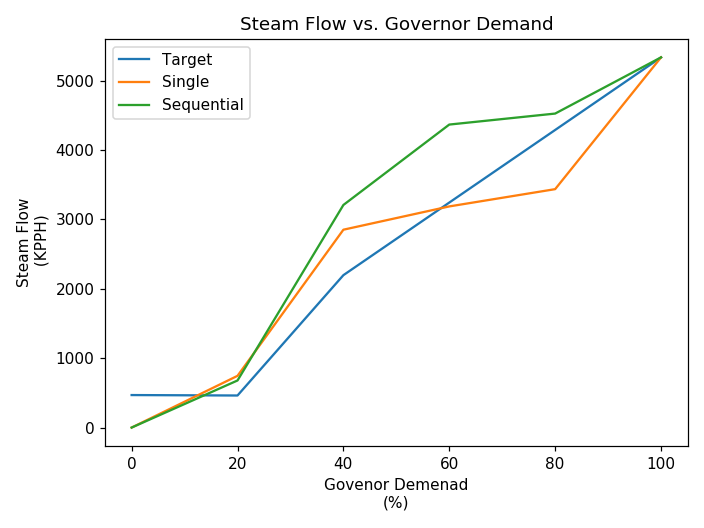

[0.1295695  0.26144794 0.34006672 0.26144794 0.34006672 0.34006672
 0.1295695  0.98527235 1.         1.         0.29530249 1.
 1.         0.29528441 1.         1.         0.29530061 1.
 1.         0.29530363 1.         1.         0.29530354 1.
 1.         0.29529689 1.         1.         0.29530515 1.
 1.         0.29529273]


In [355]:
error = calc_performance(result['x'], target_df, 0, 0)
print(result['x'])

In [9]:
#Create gif
im = []
im.append(PIL.Image.open(f"projects/{project}/plot0.png"))
im.append(PIL.Image.open(f"projects/{project}/plot405.png"))
im.append(PIL.Image.open(f"projects/{project}/plot486.png"))
im.append(PIL.Image.open(f"projects/{project}/plot729.png"))
im.append(PIL.Image.open(f"projects/{project}/plot1215.png"))
im.append(PIL.Image.open(f"projects/{project}/plot1458.png"))
im.append(PIL.Image.open(f"projects/{project}/plot1863.png"))
im.append(PIL.Image.open(f"projects/{project}/plot1944.png"))
im.append(PIL.Image.open(f"projects/{project}/plot2178.png"))
im.append(PIL.Image.open(f"projects/{project}/plot3402.png"))
im.append(PIL.Image.open(f"projects/{project}/plot3645.png"))
im.append(PIL.Image.open(f"projects/{project}/plot3888.png"))
im.append(PIL.Image.open(f"projects/{project}/plot4050.png"))
im.append(PIL.Image.open(f"projects/{project}/plot4131.png"))
im.append(PIL.Image.open(f"projects/{project}/plot6075.png"))
im.append(PIL.Image.open(f"projects/{project}/plot6237.png"))
im.append(PIL.Image.open(f"projects/{project}/plot6318.png"))
im.append(PIL.Image.open(f"projects/{project}/plot12771.png"))
im.append(PIL.Image.open(f"projects/{project}/plot12843.png"))

im[0].save(f'projects/{project}/plot.gif', format='GIF', append_images=im[1:], save_all=True, duration=200, loop=1)

<IPython.core.display.Javascript object>


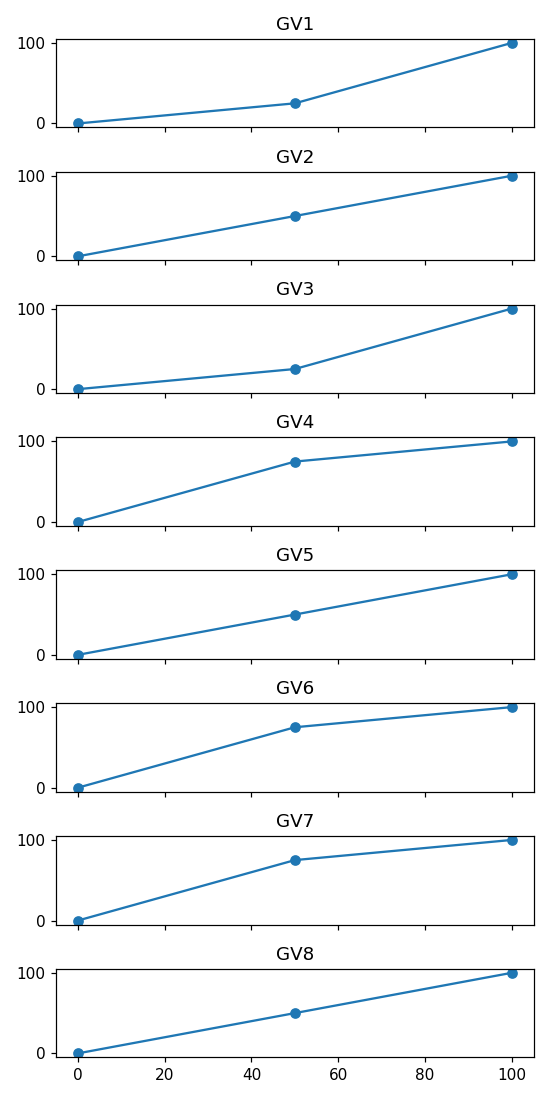

In [139]:
#show best trim curves
trim_df
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, sharex=True, figsize = (5,10))

ax1.plot(trim_df[f"GV1 lift"], trim_df[f"GV1 area"],"-o")
ax2.plot(trim_df[f"GV2 lift"], trim_df[f"GV2 area"],"-o")
ax3.plot(trim_df[f"GV3 lift"], trim_df[f"GV3 area"],"-o")
ax4.plot(trim_df[f"GV4 lift"], trim_df[f"GV4 area"],"-o")
ax5.plot(trim_df[f"GV5 lift"], trim_df[f"GV5 area"],"-o")
ax6.plot(trim_df[f"GV6 lift"], trim_df[f"GV6 area"],"-o")
ax7.plot(trim_df[f"GV7 lift"], trim_df[f"GV7 area"],"-o")
ax8.plot(trim_df[f"GV8 lift"], trim_df[f"GV8 area"],"-o")

ax1.set_title('GV1')
ax2.set_title('GV2')
ax3.set_title('GV3')
ax4.set_title('GV4')
ax5.set_title('GV5')
ax6.set_title('GV6')
ax7.set_title('GV7')
ax8.set_title('GV8')
plt.tight_layout()
plt.show()
                                          
fig.savefig(f'projects/{project}/final_trims.png')

In [303]:
parameters = [1,1,1,1,1,1,1,1,
              0.8,0.7,0.6,0.5,
              0.8,0.7,0.6,0.5,
              0.8,0.7,0.6,0.5,
              0.8,0.7,0.6,0.5,
              0.8,0.7,0.6,0.5,
              0.8,0.7,0.6,0.5,
              0.8,0.7,0.6,0.5,
              0.8,0.7,0.6,0.5
             ]

res = int((len(parameters) - gov_no)/gov_no)
p_lists=[]

p_lists.append(guess[:8])
for i in range(gov_no):
    sliceObj = slice(8+i*res, 8+(i+1)*res)
    p_lists.append(parameters[sliceObj])

print(p_lists[0])

trim_intermed = []
for i in range(gov_no):
    
    #define the number to base the guess on 
    trim_intermed.append(p_lists[i+1])

print(trim_intermed[0])
trim_guess_indiv = []

print(res)
trim_guess = []
for x in range(gov_no):
    trim_guess_indiv = []
    if res == 1:
        trim_guess_indiv.append(100*trim_intermed[x][0])
    else:
        trim_guess_indiv.append(100*trim_intermed[x][0])
        for i in range(res-1):
            trim_guess_indiv.append(trim_guess_indiv[i]*trim_intermed[x][i+1])
    
    trim_guess.append(trim_guess_indiv)
            

[1, 1, 1, 1, 1, 1, 1, 1]
[0.8, 0.7, 0.6, 0.5]
4


In [287]:
trim_guess.append(trim_guess[0]*trim_intermed[0][1])

In [288]:
trim_guess.append(trim_guess[1]*trim_intermed[0][2])

In [304]:
trim_guess

[[80.0, 56.0, 33.6, 16.8],
 [80.0, 56.0, 33.6, 16.8],
 [80.0, 56.0, 33.6, 16.8],
 [80.0, 56.0, 33.6, 16.8],
 [80.0, 56.0, 33.6, 16.8],
 [80.0, 56.0, 33.6, 16.8],
 [80.0, 56.0, 33.6, 16.8],
 [80.0, 56.0, 33.6, 16.8]]

In [331]:
trim_guess[0]


[80.0, 56.0, 33.6, 16.8]

In [333]:
trim_guess[0].reverse()

In [334]:
trim_guess[0]

[16.8, 33.6, 56.0, 80.0]